# Credit Card Fraud Detection

Due to the COVID pandemic and the increase of both online shopping adoption and e-commerce platforms, the presence of fraudsters is also rising in the online world. Card Not Present (CNP) Fraud represents most of the money lost due to credit card fraud ([European Central Bank, 2019](https://www.ecb.europa.eu/pub/cardfraud/html/ecb.cardfraudreport202008~521edb602b.en.html#toc2)).

With the motivation to provide a good solution to the problem at hand, in this notebook we will review the main techniques used to get a sense of the data we may use and to transform those entries into actionable information. Later on, we will try to design and train a machine learning model to get predictions and evaluate those predictions to see if the model could be used to reduce fraud in our hypothetical webshop.

In [28]:
from collections import Counter

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import tensorflow as tf

## Data Loading

In [3]:
fraud = pd.read_csv("../data/creditcard.csv")

In [7]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Understanding

In [8]:
# Number of columns by data type
print(Counter(fraud.dtypes))

Counter({dtype('float64'): 30, dtype('int64'): 1})


In [9]:
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


    Class         %
0  284315  0.998273
1     492  0.001727


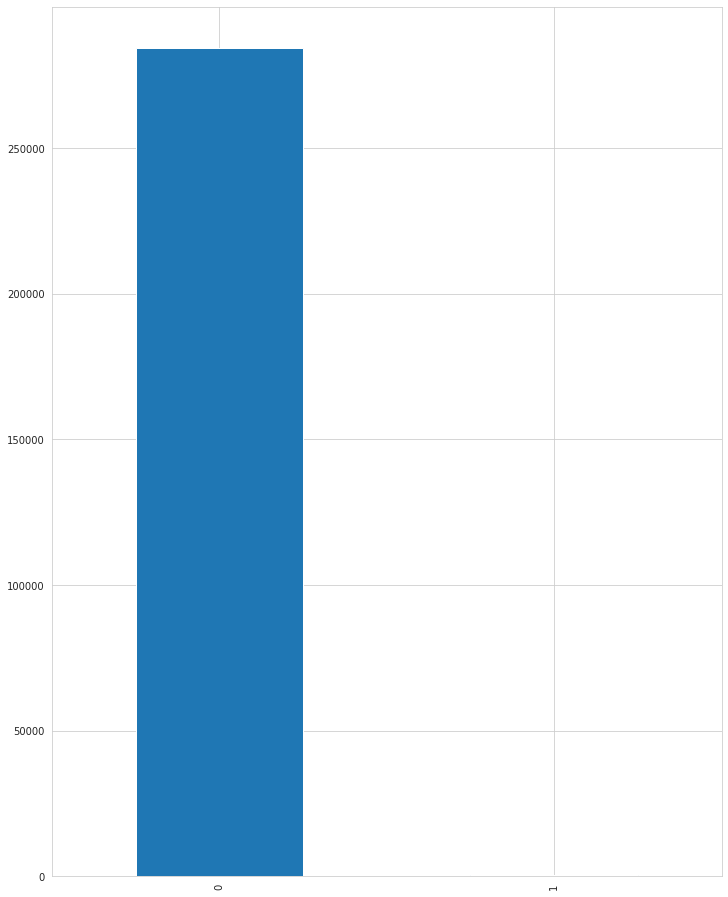

In [25]:
# % of each class
class_counts = pd.DataFrame(fraud["Class"].value_counts(),)
class_counts["%"] = class_counts["Class"] / class_counts["Class"].sum()
print(class_counts)
class_counts["Class"].plot(kind='bar', figsize=(12, 16))
plt.show()

The dataset is composed by 30 columns with decimal values and 1 with integer values, which represents the target binary variable.

Apart from the target `Class` variable, we should also notice the presence of `Time` and `Amount` columns, which are features used historically to model solutions against fraud due to their capability to represent different patterns of shopping.

Most of the columns, those starting with the letter `V`, are the outcome of a dimensionality reduction procedure on the original dataset, so we may not infer the meaning of the columns in the context of the problem. Although, we do can use them to infer if a transaction is fraudulent or not, as the dimensionality reduction should have kept their variability explained at a high rate, if not at 100%, which means all these columns could be used by our models to determine a decision boundary regarding our particular use case.

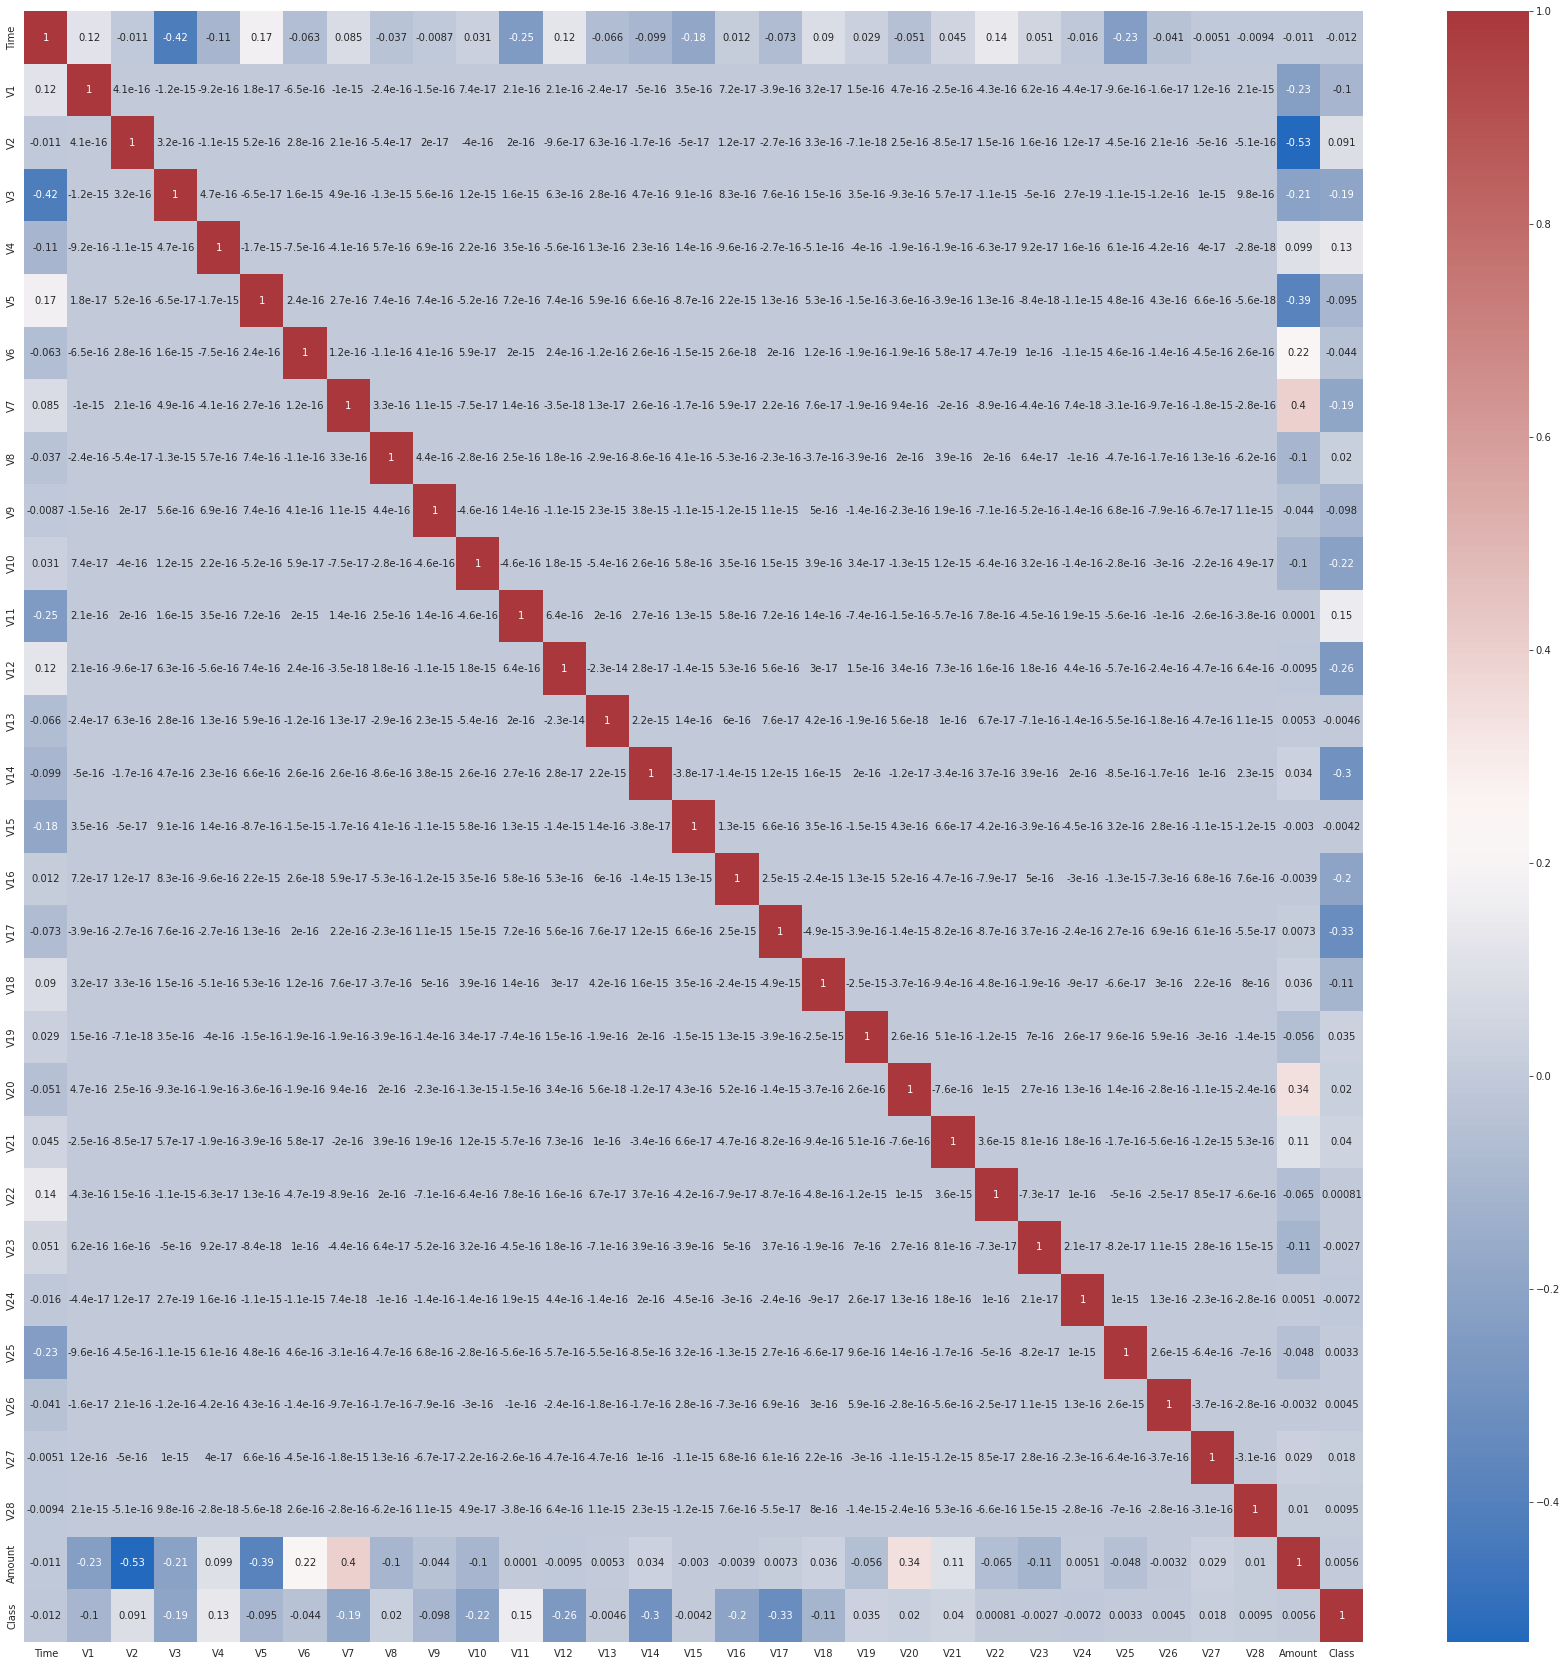

In [24]:
# Pearson correlation
pearson_correlation = fraud.corr()
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(pearson_correlation, annot=True, cmap=sns.color_palette("vlag", as_cmap=True), ax=ax)
plt.show()

On the correlation matrix, we may focus our attention to the columns from which we know the meaning in order to get the most plausible conclusions.

If we start with our target variable, we see some minor correlations with several columns, including `Time` and `Amount`, which may induce us to believe that neither of them is specially important by itself to determine if a transaction is fraudulent or not. On the other hand, some columns encoded as V17 or V14 seem to have a strong enough correlation with the target column by themselves, and this pattern is also seen (less noticeable though) in other encoded columns as V3, V10 or V12.

Secondly, by observing the matrix we do see a correlation in time with variables V3, V15 and V25, so these features could be encoding the variability of dimensions such as the seasonality of the products included in the order or the time at which the order was done.

Finally, we also perceive that there are several columns that seem to be highly correlated to the amount, such as V2, V5 and V7, which could represent categories of items that depend on the price or demographic values that affects the average order value of a certain group of orders.

In [ ]:
# Show distributions of Time and Amount
fig, ax = plt.subplots(figsize=(24, 16), nrows=2)
sns.distplot(fraud["Time"], ax[0], color='blue')
sns.distplot(fraud["Amount"], ax[1], color='green')
plt.show()

In [ ]:
# Eliminate outliers using IQR
fraud_transformed = fraud.copy()


# Scaled data

Dimensionality reduction, as we see, is useful to see if we could separate the classes using simple transformations. On the plot we see that there are groups of transactions completely isolated and separated from the

The conclusion of this analysis is that the dataset is likely to have enough information and the correlation of different variables with the classes' allocation seems to be enough to model a solution which should be successful up to the standards expected on the problem.

## Data Modelling

In [ ]:
# Include resamplers into pipeline


### Logistic Regression

### Decision Tree

### Random Forest

### XGBoost

### Fully Connected Network

## Conclusions

In [27]:
# Create table displaying results by resampler and model